In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as plt
pd.set_option("display.max_columns",999)
import numpy as np
import json

# Getting some info from JSON file

## Data set preparation, run everything to get from scratch

In [2]:
def extractLoc(tweet):
    tweetLoc={}
    if 'user' in tweet:
        tweetLoc['location']=tweet['user']['location']  
        tweetLoc['time_zone']=tweet['user']['time_zone']
    else:
        tweetLoc['location']=None
        tweetLoc['time_zone']=None
    # try to geolocate the tweet
    if 'coordinates' in tweet and tweet['coordinates']!=None:
        tweetLoc['lat']=tweet['coordinates']['coordinates'][0]
        tweetLoc['lon']=tweet['coordinates']['coordinates'][1]
    else:
        tweetLoc['lat']=None
        tweetLoc['lon']=None
        
    if 'place' in tweet and tweet['place']!=None:
        tweetLoc['country']=tweet['place']['country']
        tweetLoc['place']=tweet['place']['full_name']
    else:
        tweetLoc['country']=None
        tweetLoc['place']=None 
    return tweetLoc
    
# info from https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object
def extractInfo(tweet):
    tweetInfo={}
    # basic tweet info
    tweetInfo['id']=tweet['id']
    tweetInfo['created_at']=tweet['created_at']
    tweetInfo['quote_count']=tweet['quote_count'] if 'quote_count' in tweet else None 
    tweetInfo['retweet_count']=tweet['retweet_count']
    tweetInfo['favorite_count']=tweet['favorite_count']
    
    # This tweet user data
    tweetInfo['statuses_count']=tweet['user']['statuses_count']
    tweetInfo['user_followers_count']=tweet['user']['followers_count']
    tweetInfo['user_screen_name']=tweet['user']['screen_name'] 
    tweetInfo['user_id']=tweet['user']['id'] 
    
    # get tweet location
    location = extractLoc(tweet)
    for k in location.keys():
        tweetInfo[k]=location[k]
        
    # type of tweet
    if tweet['in_reply_to_status_id']!=None: # reply
        tweetInfo['tweet_type']='reply'
        tweetInfo['parent_id']=tweet['in_reply_to_status_id']
        tweetInfo['full_text']=tweet['full_text']
        tweetInfo['parent_text']=None
        tweetInfo['parent_user_id']=tweet['in_reply_to_user_id']
        tweetInfo['parent_user_followers']=None  
        tweetInfo['parent_created_at']=None  
        subtweet={}
    elif 'quoted_status' in tweet: # quote
        tweetInfo['tweet_type']='quote'
        tweetInfo['parent_id']=tweet['quoted_status_id']
        tweetInfo['full_text']=tweet['full_text']
        subtweet = tweet['quoted_status']
        tweetInfo['parent_text']=['full_text']
        tweetInfo['parent_user_id']=subtweet['user']['id']
        tweetInfo['parent_user_followers']=subtweet['user']['followers_count']
        tweetInfo['parent_created_at']=subtweet['created_at']
    elif'retweeted_status' in tweet and tweet['retweeted_status']!=None: # retweet
        tweetInfo['tweet_type']='retweet'
        subtweet = tweet['retweeted_status']
        tweetInfo['parent_id']=subtweet['id']
        tweetInfo['full_text']=tweet['full_text']
        tweetInfo['parent_text']=subtweet['full_text']
        tweetInfo['parent_user_id']=subtweet['user']['id']
        tweetInfo['parent_user_followers']=subtweet['user']['followers_count']
        tweetInfo['parent_created_at']=subtweet['created_at'] 
    else: # iriginal
        tweetInfo['tweet_type']='original'
        tweetInfo['parent_id']=None
        tweetInfo['full_text']=tweet['full_text']
        tweetInfo['parent_text']=None
        tweetInfo['parent_user_id']=None
        tweetInfo['parent_user_followers']=None 
        tweetInfo['parent_created_at']=None  
        subtweet={}
    
    # get subtweet location
    location = extractLoc(subtweet)
    for k in location.keys():
        tweetInfo['parent_'+k]=location[k]
                    
    return tweetInfo

In [3]:
tweets={}
tweetfile=open("../../File requests/cuentalos/Aniol-Maria-cuentalo-search-20180427_20180513.jsonl")
for idx,line in enumerate(tweetfile):
    if idx>10000000: # use for testing
        break
    tweet=json.loads(line)
    try:
        tweets[tweet['id']]=extractInfo(tweet)
    except:
        print(tweet)
        break

In [4]:
#EXPERIMENT
'''tweets={}
tweetfile=open("../../File requests/cuentalos/Aniol-Maria-cuentalo-search-20180427_20180513.jsonl")
for idx,line in enumerate(tweetfile):
    tweet=json.loads(line)
    if tweet['in_reply_to_status_id']!=None:
        print(tweet)
        break'''

'tweets={}\ntweetfile=open("../../File requests/cuentalos/Aniol-Maria-cuentalo-search-20180427_20180513.jsonl")\nfor idx,line in enumerate(tweetfile):\n    tweet=json.loads(line)\n    if tweet[\'in_reply_to_status_id\']!=None:\n        print(tweet)\n        break'

In [5]:
df=pd.DataFrame(tweets).transpose()
len(df)

2111998

In [6]:
df.dtypes

country                  object
created_at               object
favorite_count           object
full_text                object
id                       object
lat                      object
location                 object
lon                      object
parent_country           object
parent_created_at        object
parent_id                object
parent_lat               object
parent_location          object
parent_lon               object
parent_place             object
parent_text              object
parent_time_zone         object
parent_user_followers    object
parent_user_id           object
place                    object
quote_count              object
retweet_count            object
statuses_count           object
time_zone                object
tweet_type               object
user_followers_count     object
user_id                  object
user_screen_name         object
dtype: object

In [7]:
df['created_at']=pd.to_datetime(df.created_at,infer_datetime_format=True)
df['parent_created_at']=pd.to_datetime(df.parent_created_at,infer_datetime_format=True)

In [8]:
df.retweet_count=df.fillna(-1).retweet_count.astype(np.int32)
df.quote_count=df.quote_count.fillna(-1).astype(np.int32)
df.statuses_count=df.statuses_count.fillna(-1).astype(np.int32)
df.user_followers_count=df.user_followers_count.fillna(-1).astype(np.int32)
df.parent_user_followers=df.parent_user_followers.fillna(-1).astype(np.int32)

df.lat=df.lat.fillna(-999).astype(np.float32)
df.lon=df.lon.fillna(-999).astype(np.float32)

In [9]:
df.id=df.fillna(0).id.astype(np.int64)
df.parent_id=df.parent_id.fillna(0).astype(np.int64)
df.parent_user_id=df.parent_user_id.fillna(0).astype(np.int64)
df.user_id=df.user_id.fillna(0).astype(np.int64)


In [10]:
df.head()

,country,created_at,favorite_count,full_text,id,lat,location,lon,parent_country,parent_created_at,parent_id,parent_lat,parent_location,parent_lon,parent_place,parent_text,parent_time_zone,parent_user_followers,parent_user_id,place,quote_count,retweet_count,statuses_count,time_zone,tweet_type,user_followers_count,user_id,user_screen_name
990380137937035265,None,2018-04-28 23:59:59,0,RT @Odi_sea: Con 17 años desde una cena de gra...,990380137937035265,-999.0,Venezuela,-999.0,None,2018-04-28 00:41:56,990028305704333312,None,,None,None,Con 17 años desde una cena de graduación un ho...,Amsterdam,301,112541236,None,-1,3176,48132,Caracas,retweet,1839,636716479,OrianaDiAmeliee
990380135638593538,None,2018-04-28 23:59:59,0,RT @__Kylene: Demos voz y apoyo a esta compañe...,990380135638593538,-999.0,"Baker Street, London.",-999.0,None,2018-04-28 14:57:54,990243714584010752,None,Lleida,None,None,Demos voz y apoyo a esta compañera que me ha p...,Athens,2483,814900356,None,-1,1208,9376,None,retweet,249,546250792,alannih
990380135500181505,None,2018-04-28 23:59:59,0,RT @AlejandraTuk: Mi marido me maltrata.\nPido...,990380135500181505,-999.0,,-999.0,None,2018-04-28 20:21:05,990325049893801984,None,Latinoamérica Libre ☭,None,None,Mi marido me maltrata.\nPido el divorcio.\nEl ...,Eastern Time (US & Canada),5824,529588816,None,-1,17406,10839,None,retweet,132,796195177400532993,DiKa2Pa21
990380134715871233,None,2018-04-28 23:59:59,0,RT @Antiintermedio: ¿Sabéis dónde estaban hace...,990380134715871233,-999.0,"Cáceres, España",-999.0,None,2018-04-27 21:50:49,989985242713919488,None,En el combate metapolítico,None,None,¿Sabéis dónde estaban hace 4 años y medio los ...,None,18184,2345903802,None,-1,1322,41093,None,retweet,213,936556720670863360,FranciscoJMArau
990380130362187776,None,2018-04-28 23:59:58,0,RT @Soy_Arbitra: Estar en un campo de fútbol a...,990380130362187776,-999.0,"Vallecas, Madrid",-999.0,None,2018-04-28 16:07:55,990261338810257408,None,España,None,None,"Estar en un campo de fútbol arbitrando, escuch...",Athens,1676,1538698825,None,-1,573,209,None,retweet,41,2734383970,geeeelaaaaa


In [11]:
#generar fichero
df.to_pickle("./cuentalo_json_to.pkl")

In [12]:
df.columns

Index(['country', 'created_at', 'favorite_count', 'full_text', 'id', 'lat',
       'location', 'lon', 'parent_country', 'parent_created_at', 'parent_id',
       'parent_lat', 'parent_location', 'parent_lon', 'parent_place',
       'parent_text', 'parent_time_zone', 'parent_user_followers',
       'parent_user_id', 'place', 'quote_count', 'retweet_count',
       'statuses_count', 'time_zone', 'tweet_type', 'user_followers_count',
       'user_id', 'user_screen_name'],
      dtype='object')

In [13]:
len(df)

2111998

### Opcion 2: leer de fichero

df=pd.read_csv("./cuentalo_json_to.csv",index_col=0, quotechar='"', dtype={
 'country': object,
 'created_at': object,
 'favorite_count': object,
 'full_text': object,
 'id': object,
 'lat': object,
 'location': object,
 'lon': object,
 'parent_country': object,
 'parent_created_at': object,
 'parent_id': object,
 'parent_lat': object,
 'parent_location': object,
 'parent_lon': object,
 'parent_place': object,
 'parent_text': object,
 'parent_time_zone': object,
 'parent_user_followers': object,
 'parent_user_id': object,
 'place': object,
 'quote_count': object,
 'retweet_count': object,
 'statuses_count': object,
 'time_zone': object,
 'tweet_type': object,
 'user_followers_count': object,
 'user_id': object,
 'user_screen_name': object})

In [14]:
_df = pd.read_pickle("./cuentalo_json_to.pkl")

### How many tweets per 5 minutes?

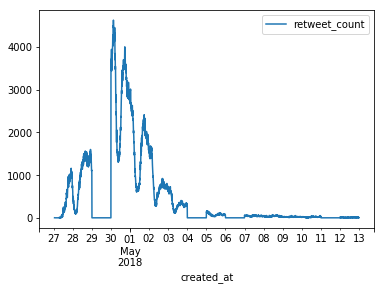

In [19]:
df[['created_at','retweet_count']].set_index('created_at').resample('5T').count().plot()

There are two days missing ? 

Roughly a peak of 5K tweets is a lot. We could try a smaller time window but then horizontally we'll get too many points. (2 weeks at 5 min are 4032 points, every 2 minutes we have 10080)


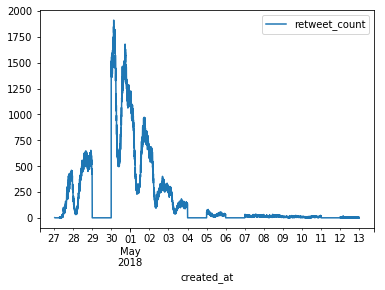

In [20]:
df[['created_at','retweet_count']].set_index('created_at').resample('2T').count().plot()

### Analysis of retweets vs...

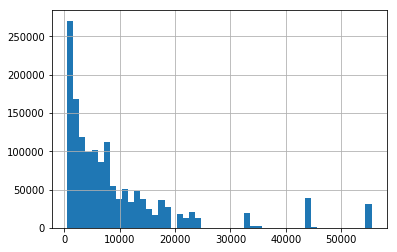

In [21]:
# How many retweets per tweet?
df[df.retweet_count>500].retweet_count.hist(bins=50)

There are a lot with fewer than 500 retweets...

In [22]:
len(df[df.retweet_count<=500])

630689

Tweets with small # of retweets are distributed nicely

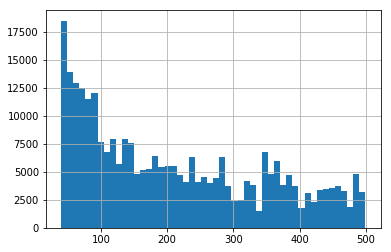

In [23]:
df[(df.retweet_count<500) & (df.retweet_count>39)].retweet_count.hist(bins=50)

### Analizing the nature of RTs

In [24]:
# cuantos tipos de tweets hay?
df.groupby('tweet_type')['id'].count()

tweet_type
original     111337
quote          8084
reply         19374
retweet     1973203
Name: id, dtype: int64

In [25]:
# cuantos retweets acumulan los replys?
replies=df[df.tweet_type=="reply"]
print(replies.retweet_count.sum())

63883


In [26]:
# Numero de tweets unicos que fueron retweeteados
len(df.parent_id.unique())

77735

In [27]:
# how do we check if the RT count is the same for each new RT?
retweets=df[df['tweet_type']=='retweet']
grouped_retweets=retweets.groupby('parent_id')

In [28]:
df.retweet_count.head()

990380137937035265     3176
990380135638593538     1208
990380135500181505    17406
990380134715871233     1322
990380130362187776      573
Name: retweet_count, dtype: int32

In [29]:
# tweet Ids que cambian el numero de RTs, los que no cambian 
(len(grouped_retweets['retweet_count'].std()[grouped_retweets['retweet_count'].std()>0]),
len(grouped_retweets['retweet_count'].std()[grouped_retweets['retweet_count'].std()==0]))

(2821, 32536)

In [30]:
grouped_retweets['retweet_count'].std()[grouped_retweets['retweet_count'].std()>0]

parent_id
989554972697251845      0.100248
989801589853577216      0.164349
989807397865771008      0.106600
989811233984573441      0.224529
989828567285592066      0.079305
989831887769296896      0.040893
989832869584482305      0.130189
989833471462961154      1.253005
989833781572964352      0.154303
989835175969239041      0.135229
989835963470934016      0.133659
989838641341042688      1.031656
989839247346675712      7.343900
989842625825005568      0.707107
989842935591161856      0.333333
989843974541185024      0.063725
989844061115895808      0.074124
989844299822059520      0.224857
989845444946743296      0.039936
989846763115868160      0.137685
989850774019723267      0.387244
989855760728363010      0.082338
989856551736365059      0.470871
989857321508536320      0.229416
989857492317474816      0.196116
989857597191802881      0.707107
989861828447567873      0.112503
989864554753609728      0.448963
989864640887902209      1.335748
989867554276544514      0.064084


In [31]:
### Vamos a clasificar los tweets que cambian o no sus RTs para observarlos
grouped_retweets.retweet_count.std().dropna().sort_values(ascending=False)

parent_id
991464409825505280    700.623534
994495599788556289    579.534600
990896349544579072    529.570540
991818513395408896    499.717871
991784392900083712    323.333529
991907915463262208    323.009336
992177026294583296    293.017860
992541961390317569    277.901188
989948689908191232    277.512085
991788720239075328    261.947767
990201907456208896    258.424676
992203314694639616    242.587631
990265452864720896    219.813247
991871539992760320    216.508588
990285709293572096    168.001208
991735320327704576    164.197185
990251871376953345    163.561052
990259278240886785    151.767575
990266465545793542    136.919583
990325049893801984    129.277499
991827719540432898    119.193593
991217730601848834    108.651209
990370802523656192    107.510113
990301881925881856    107.321699
990306246078140416    104.247551
992097239672606720    103.641015
991888394795077632    102.186011
991789885131579393    101.961495
991839836469366784     93.546909
991715556322697217     90.178885


In [32]:
# armamos una columna para cada id unico y vemos si cambia su numero de RT
RTs_with_changing_rts=pd.DataFrame(grouped_retweets['retweet_count'].std()>0)
RTs_with_changing_rts.columns=["variance_of_RT_count"]

In [33]:
# ponemos la columna en la df de retweets
retweets=retweets.merge(RTs_with_changing_rts,how="left",left_on='parent_id',right_index=True)

In [34]:
# chequeamos--tenemos el mismo numero de tweets unicos
len(retweets[retweets.variance_of_RT_count].parent_id.unique())

2821

In [35]:
# y estos 2821 tweets son RT casi 1.6M de veces
len(retweets[retweets.variance_of_RT_count])

1599673

In [36]:
# identifiquemos algunos
unidx=RTs_with_changing_rts.index[100]
retweets[retweets.parent_id==unidx][['created_at','retweet_count']]

,created_at,retweet_count
990202654226878464,2018-04-28 12:14:44,4
990200514720796672,2018-04-28 12:06:14,4
989903647474581505,2018-04-27 16:26:35,4
989825564302290944,2018-04-27 11:16:19,4


In [37]:
retweets[retweets.parent_id==991464409825505280][['created_at','retweet_count']]

,created_at,retweet_count
992192068926746624,2018-05-03 23:59:57,33117
992192064346615808,2018-05-03 23:59:56,33117
992192045824475137,2018-05-03 23:59:52,33117
992192045547745280,2018-05-03 23:59:52,33117
992192043786100736,2018-05-03 23:59:51,33117
992192041357541376,2018-05-03 23:59:51,33117
992191986898628616,2018-05-03 23:59:38,33117
992191923036319744,2018-05-03 23:59:23,33117
992191907198418944,2018-05-03 23:59:19,33117
992191851762475008,2018-05-03 23:59:06,33117


In [38]:
# check por si hay nans
retweets[np.isnan(retweets.retweet_count)]

,country,created_at,favorite_count,full_text,id,lat,location,lon,parent_country,parent_created_at,parent_id,parent_lat,parent_location,parent_lon,parent_place,parent_text,parent_time_zone,parent_user_followers,parent_user_id,place,quote_count,retweet_count,statuses_count,time_zone,tweet_type,user_followers_count,user_id,user_screen_name,variance_of_RT_count


**CONCLUSION los RTcount cambian un poco pero parece un artefacto, son muy pocos y puedo tomar o el mayor numero o el mas reciente y estará OK**

Historias de un tweet:
* Original
* Original->Retweet
* Original->Quote
* Original->Reply
* Quote->Retweet
* Quote->Quote
* Quote->Reply
* Reply->Retweet
* Reply->Quote
* Reply->Reply

In [39]:
# Ahora podemos mirar en detalle los tweets originales+quotes+replies vs los retweets.
# Estan todos?
retweeted_ids_with_maxcounts=grouped_retweets['retweet_count'].max()
retweeted_ids_with_maxcounts.head()

parent_id
646602982713360384    118
747883568735600640     12
989554972697251845    323
989604040525910017      7
989759402767859712     32
Name: retweet_count, dtype: int32

In [40]:
originals=df[df['tweet_type']=='original']
quotes=df[df['tweet_type']=='quote']
replies=df[df['tweet_type']=='reply']
# ya tengo retweets

In [41]:
historias_resumen={}

In [42]:
# tweets originales
original_ids=set(originals.id.values)
original_replied=len(original_ids.intersection(set(replies.parent_id.values)))
original_quoted=len(original_ids.intersection(set(quotes.parent_id.values)))
original_retweeted=len(original_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["originales"]={"total":len(original_ids), 
                         "respondidos":original_replied, 
                         "citados": original_quoted, 
                         "retweeted": original_retweeted}

In [43]:
# tweets respuestas
reply_ids=set(replies.id.values)
reply_replied=len(reply_ids.intersection(set(replies.parent_id.values)))
reply_quoted=len(reply_ids.intersection(set(quotes.parent_id.values)))
reply_retweeted=len(reply_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["respuestas"]={"total":len(reply_ids), 
                         "respondidos":reply_replied, 
                         "citados": reply_quoted, 
                         "retweeted": reply_retweeted}

In [44]:
# tweets quotes
quote_ids=set(quotes.id.values)
quote_replied=len(quote_ids.intersection(set(replies.parent_id.values)))
quote_quoted=len(quote_ids.intersection(set(quotes.parent_id.values)))
quote_retweeted=len(quote_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["citas"]={"total":len(quote_ids), 
                         "respondidos":quote_replied, 
                         "citados": quote_quoted, 
                         "retweeted": quote_retweeted}

In [45]:
# retweets 
retweet_ids=set(retweets.id.values)
retweet_replied=len(retweet_ids.intersection(set(replies.parent_id.values)))
retweet_quoted=len(retweet_ids.intersection(set(quotes.parent_id.values)))
retweet_retweeted=len(retweet_ids.intersection(set(retweets.parent_id.values)))
historias_resumen["retweets"]={"total":len(retweet_ids), 
                         "respondidos":retweet_replied, 
                         "citados": retweet_quoted, 
                         "retweeted": retweet_retweeted}

## Este es el resultado de esta seccion

In [46]:
pd.DataFrame(historias_resumen).transpose()

,citados,respondidos,retweeted,total
originales,1725,4885,48178,111337
respuestas,113,6375,6234,19374
citas,62,114,2819,8084
retweets,0,0,0,1973203


In [47]:
with_content_ids_set=set(list(originals.id.values)+list(quotes.id.values)+list(replies.id.values))
print ("Tweets con contenido: ",len(with_content_ids_set))
print ("De los que retweeteados: ",len(with_content_ids_set.intersection(set(retweets.parent_id.values))))
print ("Me faltarian ",len(set(list(retweets.parent_id.values)+list(replies.parent_id.values)+list(quotes.parent_id.values)).difference(with_content_ids_set))," tweets con contenido")
print ("Ademas, en la DB se mencionan ",len(df.parent_id.unique())," tweets que suman ",df[df.parent_id>0].groupby('parent_id')['retweet_count'].max().sum()," retweets")

Tweets con contenido:  138795
De los que retweeteados:  57231
Me faltarian  14057  tweets con contenido
Ademas, en la DB se mencionan  77735  tweets que suman  2787585  retweets


Los que faltan serán los de los dos días que faltan???

In [48]:
originals.head()

,country,created_at,favorite_count,full_text,id,lat,location,lon,parent_country,parent_created_at,parent_id,parent_lat,parent_location,parent_lon,parent_place,parent_text,parent_time_zone,parent_user_followers,parent_user_id,place,quote_count,retweet_count,statuses_count,time_zone,tweet_type,user_followers_count,user_id,user_screen_name
990380122082611200,None,2018-04-28 23:59:56,1,17 años.Vuelvo a casa con miedo. Se me acerca ...,990380122082611200,-999.0,,-999.0,None,NaT,0,None,None,None,None,None,None,-1,0,None,-1,0,3126,Hawaii,original,78,410012730,Angelasantos002
990380024703447040,None,2018-04-28 23:59:32,1,#Cuéntalo como hacéis las lentejas?,990380024703447040,-999.0,Cocretas del Bar,-999.0,None,NaT,0,None,None,None,None,None,None,-1,0,None,-1,0,8478,None,original,223,765926604400910337,capitancocreta
990380009549434882,None,2018-04-28 23:59:29,0,un grupo de amigas nos reunimos y salio la pla...,990380009549434882,-999.0,in they heart,-999.0,None,NaT,0,None,None,None,None,None,None,-1,0,None,-1,0,13079,Central Time (US & Canada),original,1196,2335901545,lapijadezayn_
990380001202761728,None,2018-04-28 23:59:27,5,Volvía a casa de la universidad. En el autobús...,990380001202761728,-999.0,MADRID,-999.0,None,NaT,0,None,None,None,None,None,None,-1,0,None,-1,3,6831,Athens,original,309,396794973,MariaRodas7
990379986564669441,None,2018-04-28 23:59:23,0,"Ninguna situación, por más pequeña que sea deb...",990379986564669441,-999.0,Friendzone,-999.0,None,NaT,0,None,None,None,None,None,None,-1,0,None,-1,0,293,None,original,15,838779702445805568,RainbowCloudBW


In [49]:
# What's the average number of RT per retweeted tweet?
retweeted_ids_with_maxcounts.mean()

44.45566684917389

In [50]:
# What's the variance?
retweeted_ids_with_maxcounts.std()

568.9743774456562

In [51]:
from scipy.stats import poisson
from scipy.special import factorial
import numpy as np
from scipy.optimize import curve_fit

In [52]:
cutoff=100

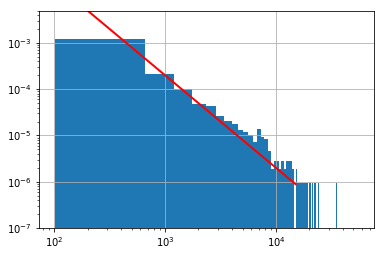

In [53]:
# Let's see the distribution of retweet counts...
x_end = 15000
fig, ax = plt.pyplot.subplots()
hist=retweeted_ids_with_maxcounts[retweeted_ids_with_maxcounts>cutoff].hist(bins=100,density=True)
x_plot = np.linspace(cutoff, x_end, 1000)
def wonk(vec,lam):
    return np.power(vec,-lam)*200 #np.exp(-vec/lam)/lam
plt.pyplot.plot(x_plot, wonk(x_plot, 2), 'r-', lw=2)  #### Roughly Power 2???
ax.set_yscale('log')
ax.set_xscale('log')
plt.pyplot.ylim((1e-7,5e-3))
plt.pyplot.show()

### Who is who

In [54]:
followers_and_retweets=pd.DataFrame()
followers_and_retweets['retweet_count']=grouped_retweets[['retweet_count','parent_id','parent_user_followers']].max().groupby('parent_id')['retweet_count'].sum()
followers_and_retweets['user_followers']=grouped_retweets[['retweet_count','parent_id','parent_user_followers']].max().groupby('parent_id')['parent_user_followers'].mean()

/Users/fcucchietti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'parent_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  
/Users/fcucchietti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'parent_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


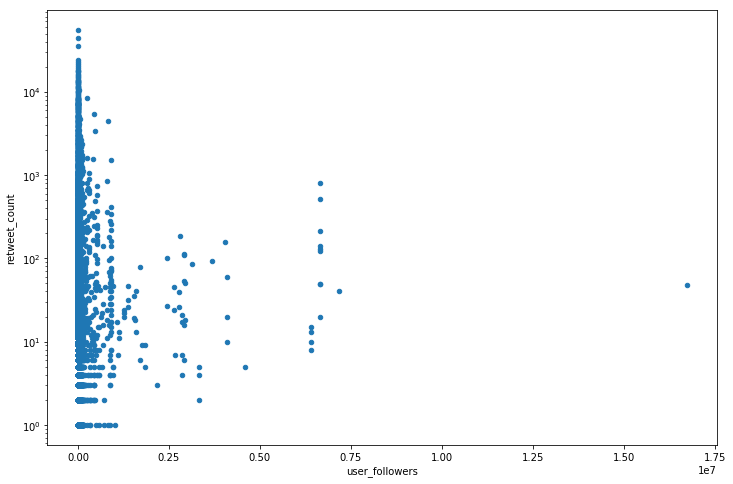

In [55]:
followers_and_retweets.plot.scatter(x='user_followers',y='retweet_count',figsize=(12,8)).set_yscale("log")

Most retweets are for people with few followers.

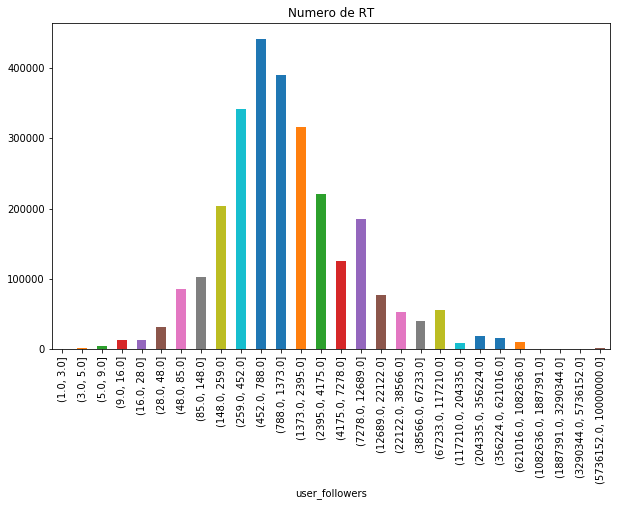

In [56]:
# partimos en rangos logaritmicos
divisiones=np.unique(np.floor(np.logspace(0,7, num=30)))
followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['retweet_count'].sum().plot.bar(figsize=(10,6),title='Numero de RT')

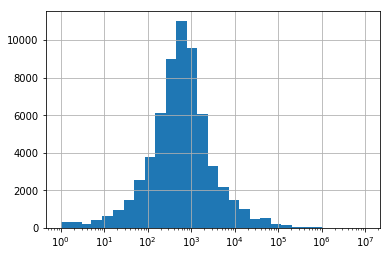

In [57]:
# Pero esto se parece a la cantidad de usuarios por bin!
followers_and_retweets['user_followers'].hist(bins=divisiones).set_xscale("log")

In [58]:
rt_count=followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['retweet_count'].sum()
user_count=followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['user_followers'].count()
follower_count=followers_and_retweets.groupby(pd.cut(followers_and_retweets['user_followers'], divisiones))['user_followers'].sum()

In [59]:
agregados_por_rango=pd.DataFrame({"user_count":user_count,"retweet_count/40":rt_count/40, "followers": follower_count})
agregados_por_rango

,user_count,retweet_count/40,followers
user_followers,,,
"(1.0, 3.0]",270,19.250,648
"(3.0, 5.0]",238,33.525,1073
"(5.0, 9.0]",402,125.800,3010
"(9.0, 16.0]",611,323.800,7816
"(16.0, 28.0]",919,333.000,20497
"(28.0, 48.0]",1480,801.300,57163
"(48.0, 85.0]",2522,2145.500,169295
"(85.0, 148.0]",3805,2558.475,444376
"(148.0, 259.0]",6092,5084.125,1233049


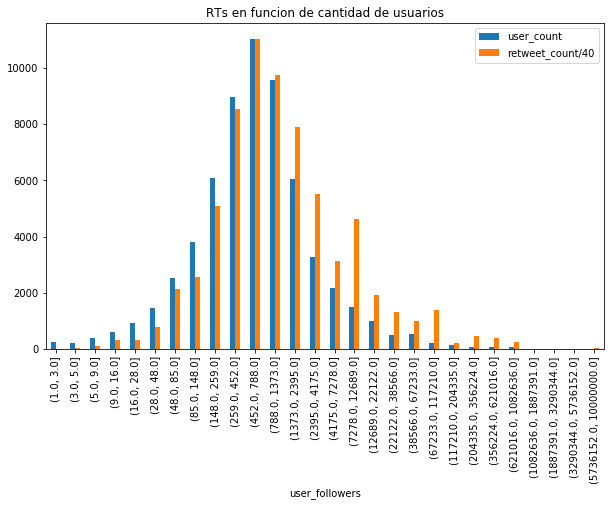

In [60]:
agregados_por_rango[["user_count","retweet_count/40"]].plot.bar(figsize=(10,6),title='RTs en funcion de cantidad de usuarios')

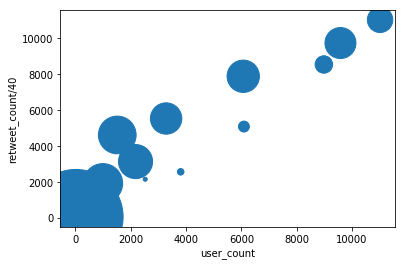

In [61]:
#creo que la cantidad de rt es que hay muchos usuarios
agregados_por_rango.plot.scatter(x="user_count",y="retweet_count/40",s=np.power(0.25*np.sqrt(follower_count/648),2))

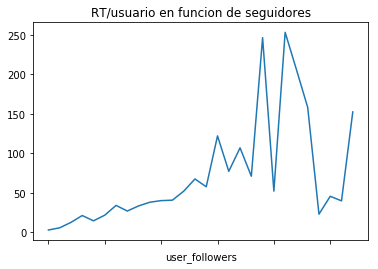

In [62]:
# en general nadie tiene un numero desproporcionado de RT 
(rt_count/user_count).plot(title="RT/usuario en funcion de seguidores")

## Timeline del hashtag -- como se disparó?

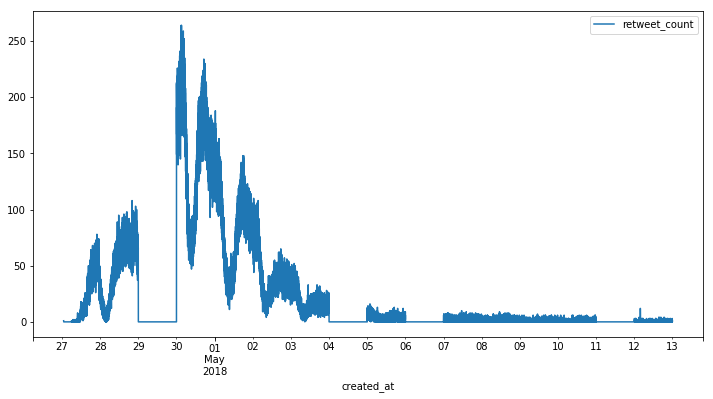

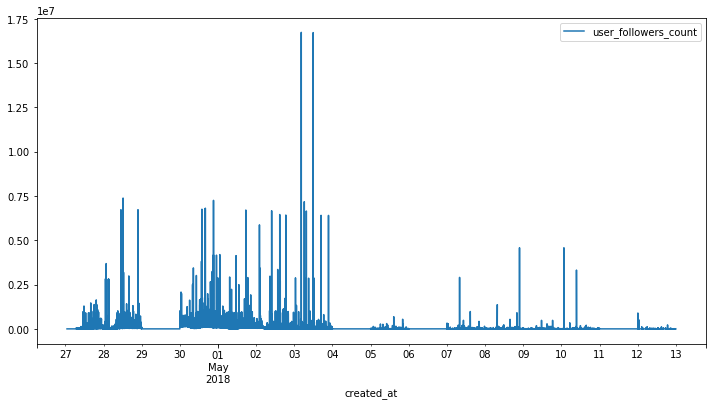

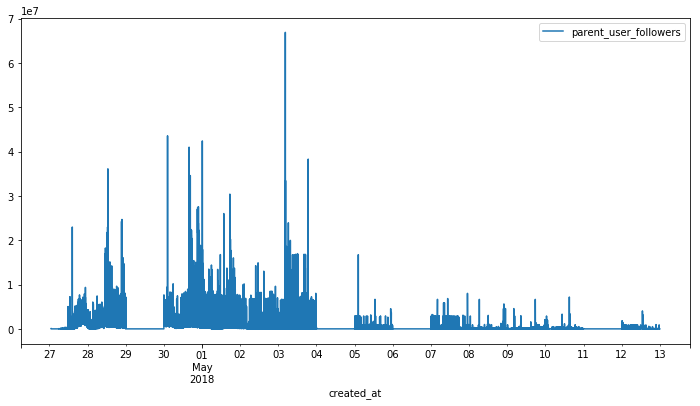

In [63]:
# RTs by influencers...? Quien disparó el cuentalo?
df[['created_at','retweet_count']].set_index('created_at').resample('15S').count().plot(figsize=(12,6))
df[['created_at','user_followers_count']].set_index('created_at').resample('15S').sum().plot(figsize=(12,6))
df[['created_at','parent_user_followers']].set_index('created_at').resample('15S').sum().plot(figsize=(12,6))

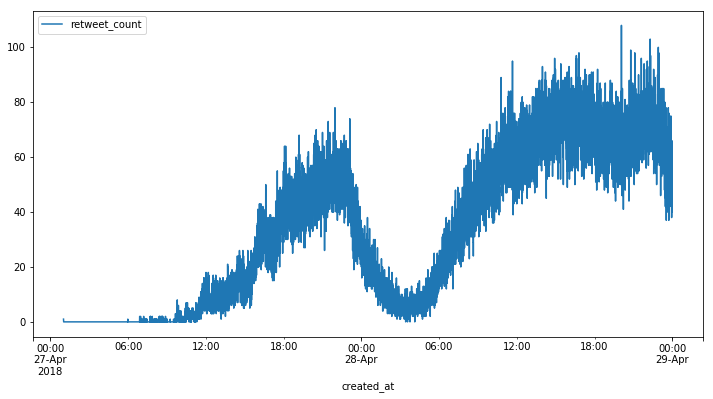

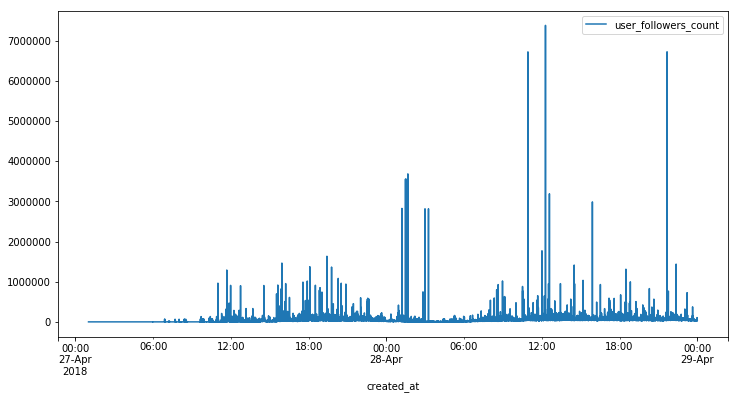

In [64]:
import datetime
df[['created_at','retweet_count']][df['created_at']< datetime.datetime(2018,4,29)].set_index('created_at').resample('15S').count().plot(figsize=(12,6))
df[['created_at','user_followers_count']][df['created_at']< datetime.datetime(2018,4,29)].set_index('created_at').resample('15S').sum().plot(figsize=(12,6))

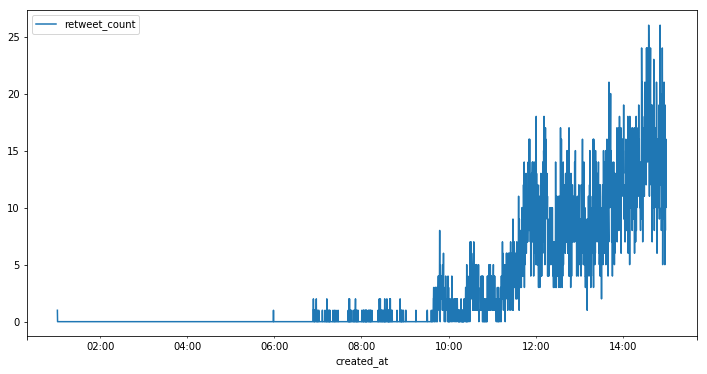

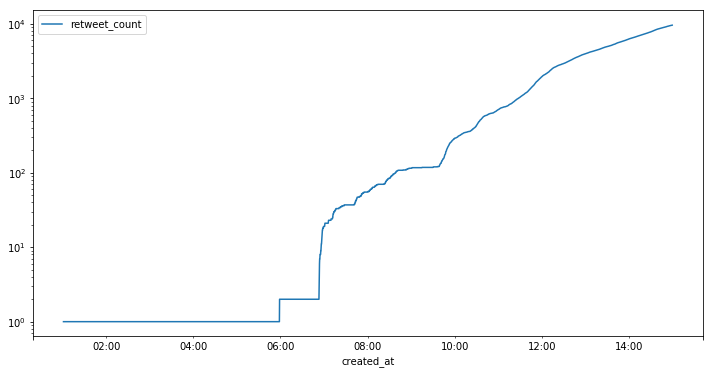

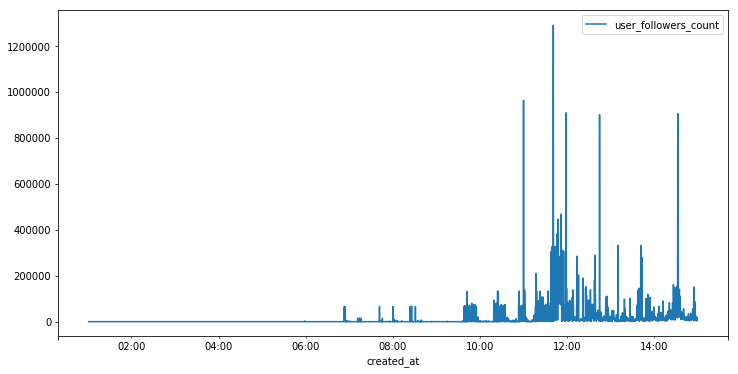

In [65]:
df[['created_at','retweet_count']][df['created_at']< datetime.datetime(2018,4,27,15,0,0)].set_index('created_at').resample('15S').count().plot(figsize=(12,6))
df[['created_at','retweet_count']][df['created_at']< datetime.datetime(2018,4,27,15,0,0)].set_index('created_at').resample('15S').count().cumsum().plot(figsize=(12,6)).set_yscale("log")
df[['created_at','user_followers_count']][df['created_at']< datetime.datetime(2018,4,27,15,0,0)].set_index('created_at').resample('15S').sum().plot(figsize=(12,6))

In [66]:
# los tweets que viralizaron #cuentalo?
# primera ola, 7 de la mañana
df[(df['created_at']< datetime.datetime(2018,4,27,7,0,0)) & (df['user_followers_count']>10000)][['created_at','user_screen_name','user_followers_count']].sort_values('user_followers_count')

,created_at,user_screen_name,user_followers_count
989759705344950273,2018-04-27 06:54:37,LaFallaras,66090
989759402767859712,2018-04-27 06:53:25,LaFallaras,66090


In [67]:
# los tweets que viralizaron #cuentalo?
# segunda ola, 10 de la mañana
df[(df['created_at']>= datetime.datetime(2018,4,27,7,0,0)) & (df['created_at']< datetime.datetime(2018,4,27,10,0,0)) & (df['user_followers_count']>10000)][['created_at','user_screen_name','user_followers_count']].groupby('user_screen_name').mean().sort_values('user_followers_count')

,user_followers_count
user_screen_name,
manubenas,14548
kolontai1959,20577
LaFallaras,66090


In [68]:
# los tweets que viralizaron #cuentalo?
# tercera ola, 11:30 de la mañana
df[(df['created_at']< datetime.datetime(2018,4,27,11,30,0)) & (df['user_followers_count']>100000)][['created_at','user_screen_name','user_followers_count']].sort_values('user_followers_count')

,created_at,user_screen_name,user_followers_count
989821531864911873,2018-04-27 11:00:17,publico_es,898092


In [69]:
# los tweets que viralizaron #cuentalo?
# 4ta ola, 12:30 de la mañana
df[(df['created_at']>= datetime.datetime(2018,4,27,11,30,0)) & (df['created_at']< datetime.datetime(2018,4,27,12,30,0)) & (df['user_followers_count']>100000)][['created_at','user_screen_name','user_followers_count']].sort_values('user_followers_count')

,created_at,user_screen_name,user_followers_count
989843365188562944,2018-04-27 12:27:03,kurioso,105327
989842344055799810,2018-04-27 12:22:59,JosePerLo,141405
989843250096750592,2018-04-27 12:26:35,Solidaridad1000,146345
989842118314164224,2018-04-27 12:22:06,lamarea_com,181573
989835426318946305,2018-04-27 11:55:30,Barbijaputa,300831
989835175969239041,2018-04-27 11:54:30,Barbijaputa,300831
989834674972299264,2018-04-27 11:52:31,Barbijaputa,300831
989834562900496386,2018-04-27 11:52:04,Barbijaputa,300831
989833577050275840,2018-04-27 11:48:09,Barbijaputa,300831
989833055543193600,2018-04-27 11:46:05,Barbijaputa,300831


In [70]:
# los tweets que viralizaron #cuentalo?
# 4ta ola, 15:00 
df[ (df['created_at']>= datetime.datetime(2018,4,27,12,30,0)) & (df['created_at']< datetime.datetime(2018,4,27,15,0,0)) & (df['user_followers_count']>100000)][['created_at','user_screen_name','user_followers_count']].sort_values('user_followers_count')

,created_at,user_screen_name,user_followers_count
989875019722510336,2018-04-27 14:32:50,MotivacionAhora,148066
989875016023138305,2018-04-27 14:32:49,MotivacionAhora,148066
989875011447083009,2018-04-27 14:32:48,MotivacionAhora,148066
989875008209145864,2018-04-27 14:32:47,MotivacionAhora,148066
989875004421607424,2018-04-27 14:32:46,MotivacionAhora,148066
989875000982364160,2018-04-27 14:32:45,MotivacionAhora,148066
989862223022579713,2018-04-27 13:41:59,lamarea_com,181573
989854302708494336,2018-04-27 13:10:31,epigmenioibarra,325243
989847882676174849,2018-04-27 12:45:00,publico_es,898092


In [71]:
###### los tweets que viralizaron #cuentalo?
# 5ta ola, tarde del 27
inid=datetime.datetime(2018,4,27,15,0,0)
endd=datetime.datetime(2018,4,28,0,0,0)
umbral=300000
df[(df['created_at']>= inid) & (df['created_at']< endd) & (df['user_followers_count']>umbral)][['created_at','user_screen_name','user_followers_count']].sort_values('user_followers_count')

,created_at,user_screen_name,user_followers_count
989988177145417733,2018-04-27 22:02:29,comentaconjose,322958
989893157662875648,2018-04-27 15:44:54,MIAREsproject,378904
989979396562878464,2018-04-27 21:27:35,luisbremer,382713
989955994687016960,2018-04-27 19:54:36,pnique,421053
989923484443774977,2018-04-27 17:45:25,lavecinarubia,425957
989924039899705344,2018-04-27 17:47:37,lavecinarubia,425957
989927513462857728,2018-04-27 18:01:25,lavecinarubia,425957
989987832642134016,2018-04-27 22:01:07,MonicaCarrillo,472315
989899792359837696,2018-04-27 16:11:16,MonederoJC,482270
989997641890172928,2018-04-27 22:40:05,srtabebi,531947


In [72]:
###### los tweets que viralizaron #cuentalo?
# 4ta ola, dia 28
inid=datetime.datetime(2018,4,28,0,0,0)
endd=datetime.datetime(2018,4,29,0,0,0)
umbral=500000
df[(df['created_at']>= inid) & (df['created_at']< endd) & (df['user_followers_count']>umbral)][['created_at','user_screen_name','user_followers_count']].sort_values('user_followers_count')

,created_at,user_screen_name,user_followers_count
990329556211982336,2018-04-28 20:39:00,324cat,507442
990193612364410880,2018-04-28 11:38:48,324cat,507465
990139051859759104,2018-04-28 08:02:00,324cat,507481
990277314134110209,2018-04-28 17:11:24,Siliconvalle,531529
990283281039003650,2018-04-28 17:35:07,srtabebi,531826
990178471547633665,2018-04-28 10:38:38,srtabebi,531903
990155410123513856,2018-04-28 09:07:00,srtabebi,531915
990155968897015808,2018-04-28 09:09:13,srtabebi,531915
990202019234316288,2018-04-28 12:12:13,iniciarsesion,579795
990194192705032194,2018-04-28 11:41:07,iniciarsesion,579800


## Otras ideas
- geolocalizar los tweets sin loc info 
- identificar tweets mas influyentes y retweeteados (mostrarlos con los identificados del timeline)
- Buscar algun modelo de impacto del tweet?
 - https://scholarspace.manoa.hawaii.edu/bitstream/10125/50160/1/paper0273.pdf
- descargar tweets originales que faltan
- encontrar el perfil tipico de usuarias que ponen contenido original
- mirar tratamiento tweets aqui: http://www.nltk.org/howto/twitter.html


# Getting info from text properties

- https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
- https://dzone.com/articles/applying-nlp-to-tweets-with-python
- https://relopezbriega.github.io/blog/2017/09/23/procesamiento-del-lenguaje-natural-con-python/
- https://pmoracho.github.io/blog/2017/01/04/NLTK-mi-tutorial/
- http://www.clubdetecnologia.net/blog/2017/aplicacion-de-nlp-a-tweets-con-python/

# Vamos a geolocalizar tweets

In [73]:
# Cuan malo es el problema?
print("con lat-lon",len(df[df.lon>-500]))
print("con pais",len(df[(df.country.notnull())]))
print("con location",len(df[(df.location!="")&(df.location!="\t")&(df.location!="\n")]))


con lat-lon 18
con pais 5269
con location 1456565


In [74]:
a=df.groupby('location').count()[['id']]

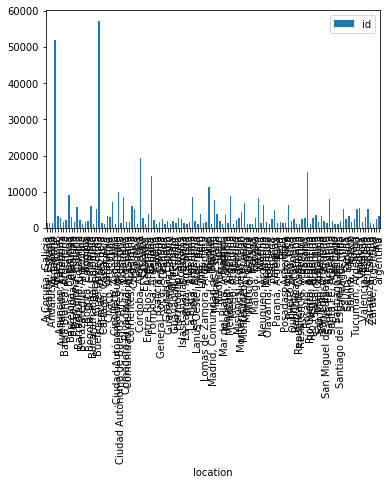

In [75]:
a[(a.id>1000)&(a.id<100000)].plot.bar()

In [76]:
df.country.dropna().unique()

array(['Spain', 'Argentina', 'France', 'Germany', 'Switzerland', 'Panama',
       'Chile', 'United Kingdom', 'Peru', 'Portugal', 'Belgium',
       'Ecuador', 'Costa Rica', 'The Netherlands', 'Andorra', 'Uruguay',
       'Mexico', 'Colombia', 'Turkey', 'Italy', 'Venezuela', 'Poland',
       'Denmark', 'Bolivia', 'Sweden', 'Ireland', '', 'Thailand',
       'Nigeria', 'United States', 'Indonesia', 'Australia', 'Bangladesh',
       'Cuba', 'Lebanon', 'Honduras', 'Paraguay', 'Guatemala', 'Brazil',
       'Nicaragua', 'Russia', 'Jamaica', 'Finland', 'El Salvador',
       'Austria', 'Canada', 'Dominican Republic', 'New Zealand', 'India',
       'Hungary', 'Norway', 'Saint Kitts and Nevis'], dtype=object)

In [77]:
df.place.unique()

array([None, 'Madrid, Spain', 'Barcelona, Spain', ...,
       'Puerto General San Martin, Argentina', 'Curacautín, Chile',
       'Böblingen, Germany'], dtype=object)

In [128]:
# attempt 1: From the data
# 
# leer paises y ciudades...
# attempt 2: 
# https://arxiv.org/pdf/1403.2345.pdf
# la proxima vez...

### Bajamos paises y ciudades
World countries: https://github.com/stefangabos/world_countries

Cities: http://www.unece.org/cefact/codesfortrade/codes_index.html, http://download.geonames.org/export/dump/

In [15]:
countries_es=pd.read_csv("./countries_es.csv")
countries_en=pd.read_csv("./countries_en.csv")
countries_en.columns=['id', 'name_en', 'alpha2', 'alpha3']

In [16]:
countries=pd.merge(countries_en[['id', 'name_en']],countries_es[['id', 'name']],on="id",how="inner")
countries.head()

,id,name_en,name
0,4,Afghanistan,Afganistán
1,248,Åland Islands,Åland
2,8,Albania,Albania
3,12,Algeria,Argelia
4,16,American Samoa,Samoa Americana


In [17]:
cities=pd.read_csv("./world-cities_csv.csv")
print(len(cities))
cities.head()

23018


,name,country,subcountry,geonameid
0,les Escaldes,Andorra,Escaldes-Engordany,3040051
1,Andorra la Vella,Andorra,Andorra la Vella,3041563
2,Umm al Qaywayn,United Arab Emirates,Umm al Qaywayn,290594
3,Ras al-Khaimah,United Arab Emirates,Raʼs al Khaymah,291074
4,Khawr Fakkān,United Arab Emirates,Ash Shāriqah,291696


In [18]:
cities.name.head()

0        les Escaldes
1    Andorra la Vella
2      Umm al Qaywayn
3      Ras al-Khaimah
4        Khawr Fakkān
Name: name, dtype: object

In [19]:
# limpiamos y estandarizamos acentos y tildes porque si no es un lio
def clean_string(string):
    clean_str=string.lower()
    clean_str=clean_str.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u').replace('è','e').replace('ü','u')
    clean_str=clean_str.replace('ñ','n')
    clean_str=clean_str.replace(',',' ').replace('-',' ').replace('+',' ').replace('.',' ').replace('/',' ')
    return clean_str

vamos a intentar usar codigos para juntar paises en castellano e ingles

In [20]:
# 
code_of_country={}
country_from_code={}
for idx,row in countries.iterrows():
    code_of_country[clean_string(row['name_en'])]=row['id']
    code_of_country[clean_string(row['name'])]=row['id']
    country_from_code[row['id']]=clean_string(row['name_en'])

country_set=set(code_of_country.keys())
cities_set=set([clean_string(x) for x in cities.name.values])

las dbs no son compatibles, arreglamos las diferencias

In [21]:
errors=set()
for row,city in cities.iterrows():
    clean_city=clean_string(city['name'])
    clean_country=clean_string(city.country)
    if clean_country in code_of_country:
        pass
    else:
        errors.add(clean_country)
print (sorted(list(errors)))

['aland islands', 'bonaire  saint eustatius and saba', 'british virgin islands', 'cape verde', 'cocos islands', 'curacao', 'czech republic', 'democratic republic of the congo', 'east timor', 'falkland islands', 'ivory coast', 'kosovo', 'moldova', 'north korea', 'palestinian territory', 'republic of the congo', 'russia', 'saint helena', 'saint martin', 'south korea', 'swaziland', 'syria', 'taiwan', 'u s  virgin islands', 'united kingdom', 'united states', 'vatican']


In [22]:
a=list(code_of_country.keys())
a.sort()
[(x, code_of_country[x]) for x in a]

[('afganistan', 4),
 ('afghanistan', 4),
 ('albania', 8),
 ('alemania', 276),
 ('algeria', 12),
 ('american samoa', 16),
 ('andorra', 20),
 ('angola', 24),
 ('anguila', 660),
 ('anguilla', 660),
 ('antarctica', 10),
 ('antartida', 10),
 ('antigua and barbuda', 28),
 ('antigua y barbuda', 28),
 ('arabia saudita', 682),
 ('argelia', 12),
 ('argentina', 32),
 ('armenia', 51),
 ('aruba', 533),
 ('australia', 36),
 ('austria', 40),
 ('azerbaijan', 31),
 ('azerbaiyan', 31),
 ('bahamas', 44),
 ('bahrain', 48),
 ('banglades', 50),
 ('bangladesh', 50),
 ('barbados', 52),
 ('barein', 48),
 ('belarus', 112),
 ('belgica', 56),
 ('belgium', 56),
 ('belice', 84),
 ('belize', 84),
 ('benin', 204),
 ('bermuda', 60),
 ('bermudas', 60),
 ('bhutan', 64),
 ('bielorrusia', 112),
 ('bolivia', 68),
 ('bolivia (plurinational state of)', 68),
 ('bonaire  san eustaquio y saba', 535),
 ('bonaire  sint eustatius and saba', 535),
 ('bosnia and herzegovina', 70),
 ('bosnia y herzegovina', 70),
 ('botsuana', 72),
 (

In [23]:
maxid=countries.id.max()

In [24]:
code_of_country['aland islands']=248
code_of_country['bonaire  saint eustatius and saba']=535
code_of_country['british virgin islands']=850
code_of_country['cape verde']=132
code_of_country['cocos islands']=166
code_of_country['curacao']=531
code_of_country['czech republic']=203
code_of_country['democratic republic of the congo']=180
code_of_country['east timor']=626
code_of_country['falkland islands']=238
code_of_country['ivory coast']=384
code_of_country['czech republic']=203
code_of_country['kosovo']=maxid+1
country_from_code[maxid+1]='kosovo'
maxid=maxid+1
code_of_country['moldova']=498
code_of_country['north korea']=408
code_of_country['palestinian territory']=275
code_of_country['republic of the congo']=180
code_of_country['russia']=643
code_of_country['saint helena']=654
code_of_country['saint martin']=663
code_of_country['south korea']=410
code_of_country['swaziland']=748
code_of_country['syria']=760
code_of_country['taiwan']=158
code_of_country['u s  virgin islands']=850
code_of_country['united kingdom']=826
code_of_country['united states']=840
code_of_country['vatican']=336

code_of_country['espanya']=724


precisamos un diccionario para saber a que paises pertenece una ciudad

In [25]:
country_of_city={}
errors=set()
for row,city in cities.iterrows():
    clean_city=clean_string(city['name'])
    clean_country=clean_string(city.country)
    if clean_country in code_of_country:
        clean_country_code=code_of_country[clean_country]
    else:
        errors.add(clean_country)
    if clean_city in country_of_city:
        country_of_city[clean_city]=country_of_city[clean_city]+[clean_country_code]
    else:
        country_of_city[clean_city]=[clean_country_code]
print (errors)

set()


In [26]:
for c in country_of_city.keys():
    if (len(country_of_city[c])>1):
        pass
        #print (c,country_of_city[c])

In [27]:
[country_from_code[x] for x in country_of_city['santiago de compostela']]

['spain']

In [28]:
check_substring('Unquillo',cities_set)

NameError: name 'check_substring' is not defined

#### Arreglamos errores puntuales encontrados a mano

In [29]:
# agregamos ciudades
if code_of_country['argentina'] not in country_of_city['santa fe']: 
    country_of_city['santa fe'].append(code_of_country['argentina'])
cities_set.add('san sebastian')
country_of_city['san sebastian']=[code_of_country['spain']]
cities_set.add('seville')
country_of_city['seville']=[code_of_country['spain']]
cities_set.add('los navalmorales')
country_of_city['los navalmorales']=[code_of_country['spain']]
cities_set.add('las palmas')
country_of_city['las palmas']=[code_of_country['spain']]
cities_set.add('cabrales')
country_of_city['cabrales']=[code_of_country['spain']]
cities_set.add('tucuman')
country_of_city['tucuman']=[code_of_country['argentina']]
cities_set.add('catamarca')
country_of_city['catamarca']=[code_of_country['argentina']]
cities_set.add('serranillos del valle')
country_of_city['serranillos del valle']=[code_of_country['spain']]
cities_set.add('godelleta')
country_of_city['godelleta']=[code_of_country['spain']]
cities_set.add('xixon')
country_of_city['xixon']=[code_of_country['spain']]
cities_set.add('almazora')
country_of_city['almazora']=[code_of_country['spain']]
cities_set.add('lar')
country_of_city['lar']=[code_of_country['spain']]
cities_set.add('mollet del valles')
country_of_city['mollet del valles']=[code_of_country['spain']]
cities_set.add('villaturiel')
country_of_city['villaturiel']=[code_of_country['spain']]
cities_set.add('mollerussa')
country_of_city['mollerussa']=[code_of_country['spain']]
cities_set.add('murchante')
country_of_city['murchante']=[code_of_country['spain']]
cities_set.add('londres')
country_of_city['londres']=[code_of_country['united kingdom']]
cities_set.add('tordesillas')
country_of_city['tordesillas']=[code_of_country['spain']]
cities_set.add('madriz')
country_of_city['madriz']=[code_of_country['spain']]
cities_set.add('madriles')
country_of_city['madriles']=[code_of_country['spain']]
cities_set.add('bcn')
country_of_city['bcn']=[code_of_country['spain']]
cities_set.add('torrellas')
country_of_city['torrellas']=[code_of_country['spain']]
cities_set.add('buenos aire')
country_of_city['buenos aire']=[code_of_country['argentina']]
cities_set.add('alacant')
country_of_city['alacant']=[code_of_country['spain']]
cities_set.add('huescar')
country_of_city['huescar']=[code_of_country['spain']]
cities_set.add('vallekas')
country_of_city['vallekas']=[code_of_country['spain']]
cities_set.add('metropolitana de santiago')
country_of_city['metropolitana de santiago']=[code_of_country['chile']]
cities_set.add('compostela')
country_of_city['compostela']=[code_of_country['spain']]
cities_set.add('distrito federal')
country_of_city['distrito federal']=[code_of_country['mexico']]
cities_set.add('nava de la asuncion')
country_of_city['nava de la asuncion']=[code_of_country['spain']]
cities_set.add('viena')
country_of_city['viena']=[code_of_country['austria']]
cities_set.add('compostela')
country_of_city['compostela']=[code_of_country['spain']]
cities_set.add('bs as')
country_of_city['bs as']=[code_of_country['argentina']]
cities_set.add('villarreal')
country_of_city['villarreal']=[code_of_country['spain']]
cities_set.add('new york')
country_of_city['new york']=[code_of_country['united states']]


#agregamos regiones
regiones={}
regiones['chubut']=code_of_country['argentina']
regiones['asturias']=code_of_country['spain']
regiones['catalunya']=code_of_country['spain']
regiones['euskal']=code_of_country['spain']
regiones['donostia']=code_of_country['spain']
regiones['catalans']=code_of_country['spain']
regiones['catalans']=code_of_country['spain']
regiones['tenerife']=code_of_country['spain']
regiones['andalucia']=code_of_country['spain']
regiones['galicia']=code_of_country['spain']
regiones['galiza']=code_of_country['spain']
regiones['asturies']=code_of_country['spain']
regiones['canarias']=code_of_country['spain']
regiones['cantabria']=code_of_country['spain']
regiones['navarra']=code_of_country['spain']
regiones['islas canarias']=code_of_country['spain']
regiones['pucela']=code_of_country['spain']
regiones['alicante']=code_of_country['spain']
regiones['republica espanola']=code_of_country['spain']
regiones['mallorca']=code_of_country['spain']
regiones['republica catalana']=code_of_country['spain']
regiones['catalonia']=code_of_country['spain']
regiones['malasana']=code_of_country['spain']
regiones['burgos']=code_of_country['spain']
regiones['espanya']=code_of_country['spain']
regiones['holanda']=code_of_country['netherlands']

regiones['inglaterra']=code_of_country['united kingdom']

#reemplazamos casos raros
country_of_city['granada']=[code_of_country['spain']]
country_of_city['madrid']=[code_of_country['spain']]
country_of_city['lima']=[code_of_country['peru']]
country_of_city['los angeles']=[code_of_country['united states']]
country_of_city['london']=[code_of_country['united kingdom']]

# quitamos ciudades que significan cosas
country_of_city.pop('san', None)
country_of_city.pop('un', None)
country_of_city.pop('una', None)
country_of_city.pop('of', None)
country_of_city.pop('fes', None)
country_of_city.pop('sur', None)
country_of_city.pop('tanga', None)
country_of_city.pop('bar', None)


[499, 804]

In [30]:
[country_from_code[c] for c in country_of_city['sevilla']]

['colombia', 'spain']

In [31]:
country_from_code[country_of_city['madrid'][0]]

'spain'

Vamos a marcar algunos husos horarios como los mas probables para algun pais en particular

In [32]:
country_from_time_zone={ x: None for x in [
    'Caracas', 'Pacific Time (US & Canada)', 'Amsterdam',
       'Hawaii', 'Athens', 'Greenland', 'Brasilia', 'Madrid',
       'Buenos Aires', 'Bogota', 'Dublin', 'Central Time (US & Canada)',
       'Belgrade', 'Central America', 'Ljubljana', 'Paris', 'Mexico City',
       'London', 'Stockholm', 'America/Bogota', 'Quito',
       'America/Argentina/Buenos_Aires', 'Bern', 'Santiago',
       'Atlantic Time (Canada)', 'Arizona', 'Casablanca',
       'Eastern Time (US & Canada)', 'Europe/Madrid',
       'Mountain Time (US & Canada)', 'America/Montevideo', 'Lisbon',
       'America/Guatemala', 'Tijuana', 'Wellington', 'Mid-Atlantic',
       'Alaska', 'America/Mexico_City', 'Berlin', 'West Central Africa',
       'Lima', 'Brisbane', 'Monterrey', 'America/Guayaquil',
       'International Date Line West', 'Brussels', 'Azores',
       'America/Hermosillo', 'Midway Island', 'America/Panama', 'Zagreb',
       'New Delhi', 'La Paz', 'Europe/Amsterdam', 'Copenhagen', 'Rome',
       'CET', 'Newfoundland', 'Vienna', 'America/Santiago', 'Georgetown',
       'America/Lima', 'Hong Kong', 'America/Manaus', 'Cape Verde Is.',
       'Europe/London', 'UTC', 'Almaty', 'Minsk', 'Budapest',
       'Guadalajara', 'America/Caracas', 'Mazatlan', 'Monrovia',
       'Baghdad', 'Moscow', 'Nairobi', 'Cairo', 'America/Barbados',
       'Skopje', 'Bratislava', 'Osaka', 'Warsaw', 'Krasnoyarsk', 'Prague',
       'Sarajevo', "Nuku'alofa", 'Tehran', 'Africa/Ceuta', 'Bangkok',
       'New Caledonia', 'Solomon Is.', 'America/Asuncion', 'Bucharest',
       'Samoa', 'Fiji', 'America/La_Paz', 'Sydney', 'Edinburgh', 'Kuwait',
       'Kamchatka', 'Irkutsk', 'America/New_York', 'Abu Dhabi',
       'Chihuahua', 'Kabul', 'Kathmandu', 'Saskatchewan', 'Sofia',
       'Canberra', 'Harare', 'Volgograd', 'Muscat',
       'America/Buenos_Aires', 'Europe/Berlin', 'Kyiv', 'Singapore',
       'Melbourne', 'Europe/San_Marino', 'Helsinki', 'Auckland', 'Seoul',
       'America/Sao_Paulo', 'Europe/Luxembourg', 'Atlantic/Canary',
       'Yerevan', 'Islamabad', 'Tokyo', 'GMT+2', 'Beijing', 'Vladivostok',
       'Istanbul', 'Dhaka', 'America/Cordoba', 'Europe/Athens', 'Darwin',
       'America/Araguaina', 'Marshall Is.', 'Novosibirsk',
       'Europe/Tirane', 'Indiana (East)', 'Jakarta', 'Europe/Paris',
       'Jerusalem', 'Europe/Rome', 'Riyadh', 'Chennai', 'Europe/Brussels',
       'Europe/Stockholm', 'America/Detroit', 'America/Chihuahua',
       'Rangoon', 'Magadan', 'Vilnius', 'GMT-5', 'Astana',
       'Europe/Belgrade', 'Adelaide', 'America/Havana', 'Baku',
       'Sri Jayawardenepura', 'Tallinn', 'America/El_Salvador', 'Karachi',
       'America/Los_Angeles', 'Tbilisi', 'Sapporo', 'Hanoi', 'Mumbai',
       'Europe/Bratislava', 'WET', 'GMT', 'Yakutsk', 'Ekaterinburg',
       'America/Puerto_Rico', 'Urumqi', 'Pretoria',
       'America/Santo_Domingo', 'ART', 'America/Costa_Rica', 'Tashkent',
       'AST', 'America/Cancun', 'Pacific/Auckland', 'America/Chicago',
       'Chongqing', 'America/Managua', 'America/Noronha',
       'Africa/Windhoek', 'GMT-3', 'Europe/Andorra', 'Hobart', 'Perth',
       'Australia/Adelaide', 'Kuala Lumpur', 'America/Denver', 'GMT-6',
       'America/Tijuana', 'America/Phoenix', 'America/Monterrey',
       'Pacific/Midway', 'CDT', 'ECT', 'America/Anguilla', 'EST',
       'Asia/Taipei', 'America/Aruba', 'Ulaan Bataar', 'GMT-4',
       'Port Moresby', 'Europe/Copenhagen', 'Guam', 'Europe/Sarajevo',
       'Asia/Tokyo', 'Asia/Shanghai', 'America/Tegucigalpa',
       'Atlantic/Azores', 'America/Glace_Bay', 'America/Belem',
       'America/Halifax', 'JST', 'Taipei', 'Atlantic/South_Georgia',
       'Atlantic/Stanley', 'Asia/Dubai', 'Riga', 'Asia/Kolkata',
       'America/Bahia_Banderas', 'America/Godthab', 'CST',
       'America/Toronto', 'PDT', 'America/Mazatlan', 'Africa/Casablanca',
       'Asia/Amman', 'Kolkata', 'America/Boise', 'Asia/Seoul',
       'Africa/Algiers', 'Africa/Nairobi', 'Europe/Moscow', 'GMT+1',
       'Asia/Calcutta', 'Kiev', 'Asia/Ho_Chi_Minh']
}
specific_tz={
'Caracas': 'venezuela', 
'Madrid': 'espana',
'Buenos Aires': 'argentina', 'Bogota': 'colombia',
'Mexico City': 'mexico',
'America/Bogota': 'colombia', 'Quito': 'ecuador',
'America/Argentina/Buenos_Aires': 'argentina',
'Santiago': 'chile',
'Europe/Madrid': 'espana',
'America/Montevideo': 'uruguay',
'America/Mexico_City': 'mexico',
'Lima': 'peru', 'Monterrey': 'mexico',
'La Paz': 'bolivia',
'America/Santiago': 'chile',
'America/Lima': 'peru',
'Guadalajara': 'mexico', 
'America/Caracas': 'venezuela'}
for tz in specific_tz:
    country_from_time_zone[tz]=code_of_country[specific_tz[tz]]

#### Ahora el codigo para identificar pais/ciudad

In [33]:
## Primero un partidor de secuencias y combinaciones (ngrams)
def find_ngrams(input_list):
    ngrams=[]
    for ng_len in range(1,len(input_list)+1):
        for ix in range(1+len(input_list)-ng_len):
            ngrams.append(" ".join(input_list[ix:ix+ng_len]))
    return ngrams

In [34]:
l='Baker Street, London.'
cl=clean_string(l)
p=find_ngrams(cl.split())
p

['baker',
 'street',
 'london',
 'baker street',
 'street london',
 'baker street london']

In [35]:
## chequear si un string y sus substrings estan en un conjunto
def check_substring(raw_string, wordlist):
    matches=[]
    string=clean_string(raw_string)
    string_parts = find_ngrams(string.split())
    for substring in wordlist: 
        if substring in string_parts: 
            matches.append(substring)
    return matches

In [100]:
check_substring(l,cities_set)

['london']

In [101]:
check_substring('Unquillo',cities_set)

['unquillo']

In [102]:
[country_from_code[c] for c in country_of_city['london']]

['united kingdom of great britain and northern ireland']

In [103]:
country_set

{'afganistan',
 'afghanistan',
 'albania',
 'alemania',
 'algeria',
 'american samoa',
 'andorra',
 'angola',
 'anguila',
 'anguilla',
 'antarctica',
 'antartida',
 'antigua and barbuda',
 'antigua y barbuda',
 'arabia saudita',
 'argelia',
 'argentina',
 'armenia',
 'aruba',
 'australia',
 'austria',
 'azerbaijan',
 'azerbaiyan',
 'bahamas',
 'bahrain',
 'banglades',
 'bangladesh',
 'barbados',
 'barein',
 'belarus',
 'belgica',
 'belgium',
 'belice',
 'belize',
 'benin',
 'bermuda',
 'bermudas',
 'bhutan',
 'bielorrusia',
 'bolivia',
 'bolivia (plurinational state of)',
 'bonaire  san eustaquio y saba',
 'bonaire  sint eustatius and saba',
 'bosnia and herzegovina',
 'bosnia y herzegovina',
 'botsuana',
 'botswana',
 'bouvet island',
 'brasil',
 'brazil',
 'british indian ocean territory',
 'brunei',
 'brunei darussalam',
 'bulgaria',
 'burkina faso',
 'burundi',
 'butan',
 'cabo verde',
 'cambodia',
 'camboya',
 'cameroon',
 'camerun',
 'canada',
 'catar',
 'cayman islands',
 'centr

In [36]:
import itertools

In [37]:
## AHORA SI LA FUNCION PRINCIPAL
def localize_tweet(row):
    country_raw=row['country']
    place_raw=row['place']
    location_raw=row['location']
    tz=row['time_zone']
    if location_raw==None or location_raw=="":
        if tz in specific_tz:
            return 1, (None,specific_tz[tz],tz) #sin info, sacado del time_zone
        return -1, (None,None,None) #sin info, texto vacio
    # clean location_raw
    location=clean_string(location_raw)
    # try to find country in location
    mentioned_countries=check_substring(location,country_set)
    # try to find city in location
    mentioned_cities=check_substring(location,cities_set)
    # try to find city in region
    mentioned_regions=check_substring(location,regiones.keys())    
    ###
    ## casos 
    ## city 0, country 0: region?
    if len(mentioned_countries)==0 and len(mentioned_cities)==0:
        if len(mentioned_regions)>0:
            return 2, (None, country_from_code[regiones[mentioned_regions[0]]],tz) #solo se menciona una region
        else:
            return -2, (None, None,tz) #no se menciona nada conocido
    ## city 0, country 1: return country
    elif len(mentioned_countries)==1 and len(mentioned_cities)==0:
        return 3, (None, mentioned_countries[0],tz)  #solo se menciona un pais  
    ## city 0, country >1: region o jerarquia?
    
    ## city 1, country 0: country from region or city
    elif len(mentioned_countries)==0 and len(mentioned_cities)==1:
        # query region
        if len(mentioned_regions)>0:
            return 4, (mentioned_cities[0], country_from_code[regiones[mentioned_regions[0]]],tz) #se menciona una ciudad y una region
        if mentioned_cities[0] in country_of_city:
            possible_countries=[country_from_code[x] for x in country_of_city[mentioned_cities[0]]]
        else:
            possible_countries = []
        if len(possible_countries)==1:
            return 5,(mentioned_cities[0], possible_countries[0],tz) #se menciona ciudad, de alli se deduce el pais
        elif len(possible_countries)==0:
            if tz in specific_tz:
                return 6, (mentioned_cities[0],specific_tz[tz],tz) #se menciona ciudad, del tz se deduce pais
            else:
                return 7, (mentioned_cities[0], None,tz) #se menciona ciudad pero no sabemos pais
        else: 
            ###### one city, many countries -- criteria?
            # time zone
            if tz in specific_tz and specific_tz[tz] in possible_countries:
                return 8, (mentioned_cities[0],specific_tz[tz],tz) #se menciona ciudad pero desempatamos pais con el tz
            # priorities? doesn´t work for latin america...?
            if 'spain' in possible_countries:
                return 9, (mentioned_cities[0],'spain',tz) #se menciona ciudad pero pueden ser varios paises, se asume españa
            elif 'united kingdom' in possible_countries:
                return 10, (mentioned_cities[0],'united kingdom',tz)#se menciona ciudad pero pueden ser varios paises, se asume UK
                  
            # set theory
            set_cit=set(possible_countries)
            if len(set_cit)==1:
                return 11, (mentioned_cities[0],list(set_cit)[0],tz) #se menciona ciudad y el mismo pais varias veces
            else:
                return -3,(mentioned_cities,possible_countries,tz)  #se menciona ciudad y no podemos discriminar entre varios posibles paises  
    ## city 1, country 1: return
    elif len(mentioned_countries)==1 and len(mentioned_cities)==1:
        return 12, (mentioned_cities[0], mentioned_countries[0],tz) #se menciona una ciudad y un pais
    ## city 1, country >1: country from city
    elif len(mentioned_countries)>1 and len(mentioned_cities)==1:
        possible_countries=[country_from_code[x] for x in country_of_city[mentioned_cities[0]]] if mentioned_cities[0] in country_of_city else []
        if tz in specific_tz and specific_tz[tz] in possible_countries:
            return 13, (mentioned_cities[0],specific_tz[tz],tz) #se menciona ciudad, desempatamos pais con tz
        # set theory, popular vote or intersections
        set_loc=set(mentioned_countries)
        set_cit=set(possible_countries)
        intersect=set_loc.intersection(set_cit)
        if len(intersect)==1:
            return 14, (mentioned_cities[0],list(intersect)[0],tz) #se menciona una ciudad y varios paises, desempatamos mirando a que pais corresponde la ciudad   
        # priorities? doesn´t work for latin america...
        all_countries = mentioned_countries+possible_countries
        if 'spain' in all_countries or 'espana' in all_countries: #se menciona una ciudad y muchos paises, si está se asume españa (1ero)
            return 15, (mentioned_cities[0],'spain',tz)
        elif 'united kingdom' in all_countries:
            return 16, (mentioned_cities[0],'united kingdom',tz) #se menciona una ciudad y muchos paises, si está se asume UK (2do)
        elif 'mexico' in all_countries:
            return 17, (mentioned_cities[0],'mexico',tz) #se menciona una ciudad y muchos paises, si está se asume mexico (3ero)
        elif 'argentina' in all_countries:
            return 17.5, (mentioned_cities[0],'argentina',tz) #se menciona una ciudad y muchos paises, si está se asume argentina (4to)
        else:
            return -4,(mentioned_cities,possible_countries,tz) #se menciona una ciudad y muchos paises, no podemos distinguir
    ## city >1, country 0: countries from cities, intersection or popular
    elif len(mentioned_countries)==0 and len(mentioned_cities)>1:
        #flatten the list of countries
        possible_countries=list(itertools.chain.from_iterable([country_of_city[city] for city in mentioned_cities if city in country_of_city]))
        possible_countries = [country_from_code[c] for c in possible_countries]
        # confirm with tz
        for city in mentioned_cities:
            if tz in specific_tz and city in country_of_city and specific_tz[tz] in country_of_city[city]:
                return 18, (city,specific_tz[tz],tz) #se menionan varias ciudades y no pais, desempatamos con tz
        # set theory, popular vote
        # this doesnt solve ties
        if len(possible_countries)>0:
            popular_country = max(set(possible_countries), key=possible_countries.count)
            for city in mentioned_cities:
                if city in country_of_city and popular_country in country_of_city[city]:
                    return 19, (city,popular_country,tz) #se menionan varias ciudades y no pais, desempatamos con el pais correspondiente que aparezca mas veces
        # longest city match wins
        # this doesnt solve ties
        longest_city=max(mentioned_cities,key=len)
        if longest_city in country_of_city:
            first_code = country_of_city[longest_city][0] #nooooo
            return 19.5, (longest_city,country_from_code[first_code],tz) #se mencionan varias ciudades y no pais, elegimos la ciudad mas larga (caracteres)
        return -5,(mentioned_cities,possible_countries,tz) #se mencionan varias ciudades y no pais, no sabemos cual puede ser
    ## city >1, country 1: countries from cities, intersection
    elif len(mentioned_countries)==1 and len(mentioned_cities)>1:
        for city in mentioned_cities:
            if city in country_of_city and mentioned_countries[0] in country_of_city[city]:
                return 20, (city,mentioned_countries[0],tz) #se menciona un pais y varias ciudades, desempatamos viendo cual corresponde
        # longest city match wins
        # this doesnt solve ties
        longest_city=max(mentioned_cities,key=len)
        return 21, (longest_city,mentioned_countries[0],tz) #se mencionan varias ciudades y un pais, elegimos la ciudad mas larga (caracteres)
        ###return -6,(mentioned_cities,mentioned_countries,tz)     
    ## city >1, country >1: countries from cities, intersection or popular
    elif len(mentioned_countries)>1 and len(mentioned_cities)>1:
        return -7,(mentioned_cities,mentioned_countries,tz) #se mencionan varias ciudades y paises, no pudimos discriminar
    # nothing reaches here
    return -8,(mentioned_cities,mentioned_countries,tz) # este error no deberia aparecer a menos que no hayamos visto todos los casos


In [156]:
# prueba para generar algunas lineas de test
count=0
testrange=50000
bundle=[]
for n in range(testrange):
    row=df.iloc[n]
    tr, ans =localize_tweet(row)
    bundle.append([row["location"],ans[0],ans[1],ans[2],tr])
    #print(tr,ans,row.location)
    count += 1 if tr>0 else 0
print ("found ",count, " places")
print (" success ", count/testrange, "given that ",(len(df)-650000)/len(df),"have location")

990380137937035265
990380135638593538
990380135500181505
990380134715871233
990380130362187776
990380129162616833
found  6  places
 success  1.2 given that  0.6922345570403002 have location


for n in range(5):
    bundle_pd=pd.DataFrame(bundle[n*10000:(n+1)*10000])
    bundle_pd.columns=["texto","ciudad","pais","huso_horario","motivo"]
    bundle_pd.to_excel("./test_geolocalizacion_tweets_"+str(n)+".xls",encoding='utf-8')

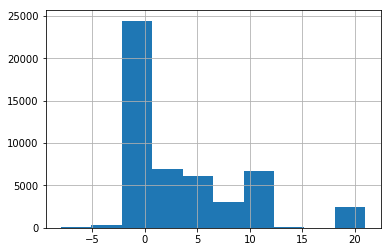

In [643]:
# esto salio con la prueba
bundle_pd=pd.DataFrame(bundle)
bundle_pd.columns=["texto","ciudad","pais","huso_horario","motivo"]
bundle_pd.motivo.hist()

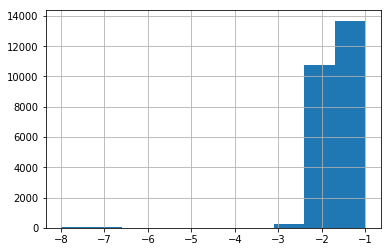

In [664]:
bundle_pd[bundle_pd.motivo<0].motivo.hist()

errores
seville


quitar granada? o poner a competir sets?
* False (['huelva', 'granada'], ['granada'], 'Greenland') El Rompido, Huelva - Granada 
* False (['avila', 'madrid'], ['espana'], None) Ávila-Madrid, España

revisar
* False (['buenos aires', 'la plata'], [], 'Brasilia') la plata , Buenos Aires 
* False (['tijuana', 'baja'], [], None) Tijuana, Baja California
* False (['ponferrada', 'madrid'], [], 'Madrid') Madrid ↔ Ponferrada
* False (['reus', 'tarragona'], [], None) Reus,Tarragona
* False (['laguna', 'la laguna'], ['espana'], None) La Laguna, Tenerife, España
* True ('barcelona', 'espana') Barcelona ✈ Madrid/Tenerife


priorizar
* False (['london'], ['canada', 'united kingdom'], None) Baker Street, London.




In [158]:
# esto tarda MUCHO -- cuidado
count=0
testrange=len(df)
final_bundle=[]
for idx,row in df.iterrows():
    tr, ans =localize_tweet(row)
    bundle = [idx,ans[0],ans[1],tr]
    if row['parent_id']>0:
        query={'country':row['parent_country'],
               'place':row['parent_place'],
               'time_zone':row['parent_time_zone'],
               'location':row['parent_location']}
        tr, ans =localize_tweet(query)
        parent_bundle = [ans[0],ans[1],tr]
    else:
        parent_bundle = [None,None,None]   
    final_bundle.append(bundle+parent_bundle)


In [160]:
final_bundle_pd=pd.DataFrame(final_bundle)
final_bundle_pd.columns=["tweet_id","ciudad_clean","pais_clean","location_diagnosis","parent_ciudad_clean","parent_pais_clean","parent_location_diagnosis"]
final_bundle_pd.to_csv("final_locations.csv",index=False)

In [38]:
# si ya lo tenemos generado, correr esto
final_bundle_pd = pd.read_csv("final_locations.csv")

##### ahora podriamos arreglar los sitios con multiples nombres y eso

In [184]:
# paises unicos
unique_countries=pd.concat([final_bundle_pd[final_bundle_pd['location_diagnosis']>0].pais_clean, final_bundle_pd[final_bundle_pd['parent_location_diagnosis']>0].parent_pais_clean]).dropna().unique()
sorted(list(unique_countries))

['afganistan',
 'afghanistan',
 'albania',
 'alemania',
 'algeria',
 'andorra',
 'angola',
 'anguilla',
 'antarctica',
 'antartida',
 'antigua and barbuda',
 'antigua y barbuda',
 'argelia',
 'argentina',
 'armenia',
 'aruba',
 'australia',
 'austria',
 'bahamas',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgica',
 'belgium',
 'belice',
 'belize',
 'benin',
 'bermuda',
 'bermudas',
 'bhutan',
 'bielorrusia',
 'bolivia',
 'bolivia (plurinational state of)',
 'bosnia and herzegovina',
 'bosnia y herzegovina',
 'brasil',
 'brazil',
 'brunei darussalam',
 'bulgaria',
 'burkina faso',
 'burundi',
 'butan',
 'camboya',
 'cameroon',
 'canada',
 'catar',
 'central african republic',
 'chile',
 'china',
 'colombia',
 'congo',
 'congo (democratic republic of the)',
 'corea del norte',
 'corea del sur',
 'costa rica',
 'croacia',
 'croatia',
 'cuba',
 'cyprus',
 'czechia',
 "côte d'ivoire",
 'denmark',
 'dinamarca',
 'dominica',
 'dominican republic',
 'ecuador',
 'egipto',
 'egypt',

In [196]:
# ciudades unicas
unique_cities=pd.concat([final_bundle_pd[final_bundle_pd['location_diagnosis']>0].ciudad_clean, final_bundle_pd[final_bundle_pd['parent_location_diagnosis']>0].parent_ciudad_clean]).dropna().unique()
cit_coun=[(c,country_from_code[country_of_city[c][0]] if c in country_of_city else "ERROR") for c in sorted(list(unique_cities))]
cit_coun_pd=pd.DataFrame(cit_coun)
cit_coun_pd.columns=["ciudad","pais"]
cit_coun_pd.to_excel("./lista_a_revisar_ciudad_pais.xls",index=False)

In [190]:
country_from_code[country_of_city['batman'][0]]

'turkey'

### Ahora los unimos con el df principal

In [39]:
df.head()

,country,created_at,favorite_count,full_text,id,lat,location,lon,parent_country,parent_created_at,parent_id,parent_lat,parent_location,parent_lon,parent_place,parent_text,parent_time_zone,parent_user_followers,parent_user_id,place,quote_count,retweet_count,statuses_count,time_zone,tweet_type,user_followers_count,user_id,user_screen_name
990380137937035265,None,2018-04-28 23:59:59,0,RT @Odi_sea: Con 17 años desde una cena de gra...,990380137937035265,-999.0,Venezuela,-999.0,None,2018-04-28 00:41:56,990028305704333312,None,,None,None,Con 17 años desde una cena de graduación un ho...,Amsterdam,301,112541236,None,-1,3176,48132,Caracas,retweet,1839,636716479,OrianaDiAmeliee
990380135638593538,None,2018-04-28 23:59:59,0,RT @__Kylene: Demos voz y apoyo a esta compañe...,990380135638593538,-999.0,"Baker Street, London.",-999.0,None,2018-04-28 14:57:54,990243714584010752,None,Lleida,None,None,Demos voz y apoyo a esta compañera que me ha p...,Athens,2483,814900356,None,-1,1208,9376,None,retweet,249,546250792,alannih
990380135500181505,None,2018-04-28 23:59:59,0,RT @AlejandraTuk: Mi marido me maltrata.\nPido...,990380135500181505,-999.0,,-999.0,None,2018-04-28 20:21:05,990325049893801984,None,Latinoamérica Libre ☭,None,None,Mi marido me maltrata.\nPido el divorcio.\nEl ...,Eastern Time (US & Canada),5824,529588816,None,-1,17406,10839,None,retweet,132,796195177400532993,DiKa2Pa21
990380134715871233,None,2018-04-28 23:59:59,0,RT @Antiintermedio: ¿Sabéis dónde estaban hace...,990380134715871233,-999.0,"Cáceres, España",-999.0,None,2018-04-27 21:50:49,989985242713919488,None,En el combate metapolítico,None,None,¿Sabéis dónde estaban hace 4 años y medio los ...,None,18184,2345903802,None,-1,1322,41093,None,retweet,213,936556720670863360,FranciscoJMArau
990380130362187776,None,2018-04-28 23:59:58,0,RT @Soy_Arbitra: Estar en un campo de fútbol a...,990380130362187776,-999.0,"Vallecas, Madrid",-999.0,None,2018-04-28 16:07:55,990261338810257408,None,España,None,None,"Estar en un campo de fútbol arbitrando, escuch...",Athens,1676,1538698825,None,-1,573,209,None,retweet,41,2734383970,geeeelaaaaa


In [40]:
final_bundle_pd.set_index(['tweet_id']).head()

,ciudad_clean,pais_clean,location_diagnosis,parent_ciudad_clean,parent_pais_clean,parent_location_diagnosis
tweet_id,,,,,,
990380137937035265,venezuela,venezuela,12.0,NaN,NaN,-1.0
990380135638593538,london,united kingdom of great britain and northern i...,5.0,lleida,spain,5.0
990380135500181505,NaN,NaN,-1.0,NaN,NaN,-2.0
990380134715871233,caceres,espana,12.0,NaN,NaN,-2.0
990380130362187776,madrid,spain,5.0,NaN,espana,3.0


In [41]:
full_df=pd.concat([df,final_bundle_pd.set_index(['tweet_id'])],axis=1)

In [42]:
full_df.head()

,country,created_at,favorite_count,full_text,id,lat,location,lon,parent_country,parent_created_at,parent_id,parent_lat,parent_location,parent_lon,parent_place,parent_text,parent_time_zone,parent_user_followers,parent_user_id,place,quote_count,retweet_count,statuses_count,time_zone,tweet_type,user_followers_count,user_id,user_screen_name,ciudad_clean,pais_clean,location_diagnosis,parent_ciudad_clean,parent_pais_clean,parent_location_diagnosis
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
990380137937035265,None,2018-04-28 23:59:59,0,RT @Odi_sea: Con 17 años desde una cena de gra...,990380137937035265,-999.0,Venezuela,-999.0,None,2018-04-28 00:41:56,990028305704333312,None,,None,None,Con 17 años desde una cena de graduación un ho...,Amsterdam,301,112541236,None,-1,3176,48132,Caracas,retweet,1839,636716479,OrianaDiAmeliee,venezuela,venezuela,12.0,NaN,NaN,-1.0
990380135638593538,None,2018-04-28 23:59:59,0,RT @__Kylene: Demos voz y apoyo a esta compañe...,990380135638593538,-999.0,"Baker Street, London.",-999.0,None,2018-04-28 14:57:54,990243714584010752,None,Lleida,None,None,Demos voz y apoyo a esta compañera que me ha p...,Athens,2483,814900356,None,-1,1208,9376,None,retweet,249,546250792,alannih,london,united kingdom of great britain and northern i...,5.0,lleida,spain,5.0
990380135500181505,None,2018-04-28 23:59:59,0,RT @AlejandraTuk: Mi marido me maltrata.\nPido...,990380135500181505,-999.0,,-999.0,None,2018-04-28 20:21:05,990325049893801984,None,Latinoamérica Libre ☭,None,None,Mi marido me maltrata.\nPido el divorcio.\nEl ...,Eastern Time (US & Canada),5824,529588816,None,-1,17406,10839,None,retweet,132,796195177400532993,DiKa2Pa21,NaN,NaN,-1.0,NaN,NaN,-2.0
990380134715871233,None,2018-04-28 23:59:59,0,RT @Antiintermedio: ¿Sabéis dónde estaban hace...,990380134715871233,-999.0,"Cáceres, España",-999.0,None,2018-04-27 21:50:49,989985242713919488,None,En el combate metapolítico,None,None,¿Sabéis dónde estaban hace 4 años y medio los ...,None,18184,2345903802,None,-1,1322,41093,None,retweet,213,936556720670863360,FranciscoJMArau,caceres,espana,12.0,NaN,NaN,-2.0
990380130362187776,None,2018-04-28 23:59:58,0,RT @Soy_Arbitra: Estar en un campo de fútbol a...,990380130362187776,-999.0,"Vallecas, Madrid",-999.0,None,2018-04-28 16:07:55,990261338810257408,None,España,None,None,"Estar en un campo de fútbol arbitrando, escuch...",Athens,1676,1538698825,None,-1,573,209,None,retweet,41,2734383970,geeeelaaaaa,madrid,spain,5.0,NaN,espana,3.0


In [169]:
#full_df.to_csv("./cuentalo_json_con_pais_ciudad.csv",index=False,header=True)

In [52]:
full_df[(full_df.pais_clean=='spain')| (full_df.parent_pais_clean=='spain')  | (full_df.pais_clean=='espana')| (full_df.parent_pais_clean=='espana') ]

,country,created_at,favorite_count,full_text,id,lat,location,lon,parent_country,parent_created_at,parent_id,parent_lat,parent_location,parent_lon,parent_place,parent_text,parent_time_zone,parent_user_followers,parent_user_id,place,quote_count,retweet_count,statuses_count,time_zone,tweet_type,user_followers_count,user_id,user_screen_name,ciudad_clean,pais_clean,location_diagnosis,parent_ciudad_clean,parent_pais_clean,parent_location_diagnosis
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
990380135638593538,None,2018-04-28 23:59:59,0,RT @__Kylene: Demos voz y apoyo a esta compañe...,990380135638593538,-999.0,"Baker Street, London.",-999.0,None,2018-04-28 14:57:54,990243714584010752,None,Lleida,None,None,Demos voz y apoyo a esta compañera que me ha p...,Athens,2483,814900356,None,-1,1208,9376,None,retweet,249,546250792,alannih,london,united kingdom of great britain and northern i...,5.0,lleida,spain,5.0
990380134715871233,None,2018-04-28 23:59:59,0,RT @Antiintermedio: ¿Sabéis dónde estaban hace...,990380134715871233,-999.0,"Cáceres, España",-999.0,None,2018-04-27 21:50:49,989985242713919488,None,En el combate metapolítico,None,None,¿Sabéis dónde estaban hace 4 años y medio los ...,None,18184,2345903802,None,-1,1322,41093,None,retweet,213,936556720670863360,FranciscoJMArau,caceres,espana,12.0,NaN,NaN,-2.0
990380130362187776,None,2018-04-28 23:59:58,0,RT @Soy_Arbitra: Estar en un campo de fútbol a...,990380130362187776,-999.0,"Vallecas, Madrid",-999.0,None,2018-04-28 16:07:55,990261338810257408,None,España,None,None,"Estar en un campo de fútbol arbitrando, escuch...",Athens,1676,1538698825,None,-1,573,209,None,retweet,41,2734383970,geeeelaaaaa,madrid,spain,5.0,NaN,espana,3.0
990380127992340480,None,2018-04-28 23:59:57,0,RT @poniatiya: Un profesor me violó durante do...,990380127992340480,-999.0,villarreal - castellón,-999.0,None,2018-04-27 22:21:06,989992861604155393,None,,None,None,Un profesor me violó durante dos años engañánd...,Pacific Time (US & Canada),415,827833578272727044,None,-1,8142,21941,Pacific Time (US & Canada),retweet,108,2260747638,mapafe_99,villarreal,spain,5.0,NaN,NaN,-1.0
990380127627415553,None,2018-04-28 23:59:57,0,RT @protestona1: Lo más triste de este HT es q...,990380127627415553,-999.0,Rivendell (Región de Eriador),-999.0,None,2018-04-27 17:13:33,989915466742272002,None,Sevilla,None,None,Lo más triste de este HT es que la mayoría de ...,Madrid,115896,1281187602,None,-1,2348,6254,Amsterdam,retweet,258,462265267,NoeliaFloresSnc,NaN,NaN,-2.0,sevilla,spain,9.0
990380119951896577,None,2018-04-28 23:59:55,0,RT @ggv_09: No es que todos seáis machistas\nE...,990380119951896577,-999.0,,-999.0,None,2018-04-28 11:07:13,990185662468026368,None,"Madrid, Espagne",None,None,No es que todos seáis machistas\nEs que todas ...,Pacific Time (US & Canada),423,1275202970,None,-1,1782,837,None,retweet,71,4885944411,yaniira_02_,NaN,NaN,-1.0,madrid,spain,5.0
990380113735966720,None,2018-04-28 23:59:54,0,RT @raaqueleta: Que aun siendo adulta tus padr...,990380113735966720,-999.0,221B Baker ST.,-999.0,None,2018-04-28 16:00:56,990259579652108289,None,Tarragona,None,None,Que aun siendo adulta tus padres te recuerden ...,Madrid,160,283452282,None,-1,1312,39274,Pacific Time (US & Canada),retweet,1423,766105535452160002,NeilGiveMeBall,NaN,NaN,-2.0,tarragona,spain,5.0
990380109214441472,None,2018-04-28 23:59:53,0,RT @luisramiromusic: Sigo alucinando. A ver. M...,990380109214441472,-999.0,Sevilla,-999.0,None,2018-04-28 10:16:44,990172959355670528,None,Madrid,None,None,Sigo alucinando. A ver. Mensaje para los hombr...,Madrid,36322,81818934,None,-1,2967,4303,Greenland,retweet,460,342262584,_Beleenn_,sevilla,spain,9.0,madrid,spain,5.0
990380107159261184,None,2018-04-28 23:59:52,0,RT @martolius: Tengo 22 años y una leve discap...,990380107159261184,-999.0,"España, La Rioja, Casalarreina",-999.0,None,2018-04-28 12:11:46,990201907456208896,None,,None,None,Tengo 22 años y una leve discapacidad psíquica...,None,1147,246789009,None,-1,54547,7557,Green

In [58]:
count_pais= full_df[(full_df['tweet_type']=='original')& (full_df['location_diagnosis']>0)].groupby('pais_clean').count()

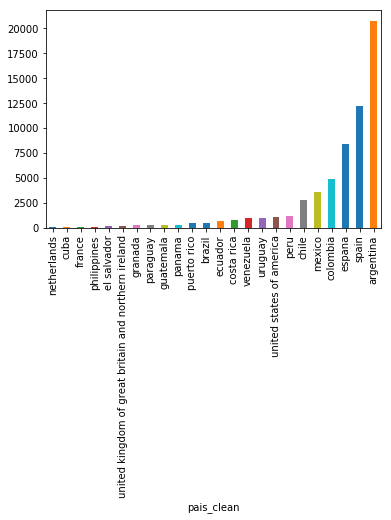

In [66]:
count_pais[count_pais.id>100].id.sort_values().plot.bar()